# Principal Component Analysis (PCA)

In many areas and across multiple disciplines, large and especially high-dimensional data sets are used that often need to be analysed or visualised. Since it is hard to visualise data that goes beyond 3D, this often requires what is known as “dimensional reduction” - a process of reducing the dimension of the data while minimising the loss of information. One of the arguably most simple and widely used dimensional reduction algorithms is Principal Component Analysis (PCA for short).
Principal component analysis is used in lots of applications including data compression, feature extraction or data visualisation $^{[1]}$.

This project intuitively explains PCA using a simple 2D example: a smiley face. An interactive tool has been created for this purpose, which visualises the example. The central concepts of principal component analysis are explained in this Jupyter notebook, where textual explanations and sections of Python code alternate. \
<font color='red'>In order to execute the programme code without errors, each section has to be run in sequence. The best way to do this is to click on **"Run all"** (Ctrl + F9) under "Runtime" in the menu in the top bar.</font> \
Now we can begin.

At first, we need some imports that are not conceptually relevant.

In [1]:
#@title Imports

# Imports

import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Label, HTML, Button, Layout
import ipywidgets as widgets

from IPython.display import display, clear_output, update_display
import IPython.display as display

from ipyevents import Event

import copy
import random

from PIL import Image, ImageDraw
import sklearn
from sklearn import decomposition

import os

$\textit{Note:}$ In graphical image processing, the x-axis in two-dimensional coordiante systems points to the right and the y-axis points downwards - instead of upwards (as in maths). This means that the origin of the coordinate system is in the top left-hand corner of a generated image, which usually only has positive values.

A smiley is defined here in simplified form by $p = 9$ points. As each two-dimensional point consists of x and y coordinates, $d = 9 * 2 = 18$ values are required to describe a smiley, which is therefore represented by an $18$-dimensional vector. \
Two consecutive values denote the x and y coordinates of a point.
As we will see later, it is crucial to maintain a consistent order of points across multiple smileys, so in our example the first two points always need to represent the eyes of a smiley, whereas the next four points must always describe a smiley's mouth and the last two its nose. In other words, our smileys need to be in correspondence. \
For example, the vector for a happy smiley looks like this:

In [2]:
happy = np.array([5.5, 1.75, 2.5, 1.75, 2, 5, 3, 5.75, 4, 6, 5, 5.75, 6, 5, 4, 3, 4, 4])

$$
\vec{v_{1}}= \left(\begin{array}{c} 5.5 \\ 1.75 \\ 2.5 \\ 1.75 \\ 2 \\ 5 \\ 3 \\ 5.75 \\ 4 \\ 6 \\ 5 \\ 5.75 \\ 6 \\ 5 \\ 4 \\ 3 \\ 4 \\ 4 \end{array}\right)
$$

$\textit{Note:}$ In the programme code, row vectors are used instead of column vectors, which means that these and matrices used later must be transposed in some cases. Therefore, the implementation of the formulas may differ from the textual explanations.

We can now also draw these points from $v_1$ that define our happy smiley:

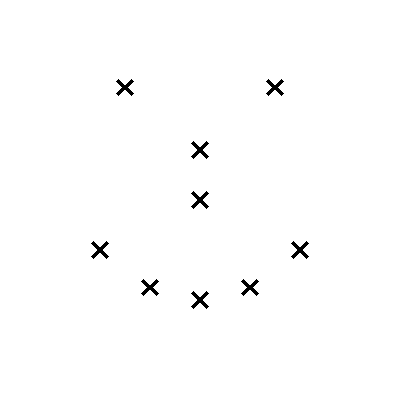

In [3]:
#@title Draw the smiley pointwise
# Ignore the code details

im = Image.new("RGB", (400, 400))
draw = ImageDraw.Draw(im)

def draw_smiley_pointwise(p: np.array, colorEyes, colorNose, colorMouth):

    p = copy.copy(p) * 50

    # Draw white background
    draw.rectangle([(0, 0), (400, 400)], "white")

    def draw_xmarks(draw, center, linelength=10, width=3, fill="black"):
        xyDiff = np.sqrt(2 * np.power(linelength/2, 2))
        coords = np.array([center[0]-xyDiff, center[1]-xyDiff, center[0]+xyDiff, center[1]+xyDiff, center[0]-xyDiff, center[1]+xyDiff, center[0]+xyDiff, center[1]-xyDiff])
        draw.line([(coords[0], coords[1]), (coords[2], coords[3])], fill=fill, width=width)
        draw.line([(coords[4], coords[5]), (coords[6], coords[7])], fill=fill, width=width)


    # Draw eyes
    right_eye_center, left_eye_center = p[0:2], p[2:4]
    draw_xmarks(draw, left_eye_center, fill=colorEyes)
    draw_xmarks(draw, right_eye_center, fill=colorEyes)

    # Draw nose
    nose_top, nose_bottom = p[14:16], p[16:18]
    draw_xmarks(draw, nose_top, fill=colorNose)
    draw_xmarks(draw, nose_bottom, fill=colorNose)

    # Draw mouth
    mouth = [p[4:6], p[6:8], p[8:10], p[10:12], p[12:14]]
    for x in mouth:
        draw_xmarks(draw, x, fill=colorMouth)

    display.display(im)


draw_smiley_pointwise(happy, "black", "black", "black")

If we colour the eyes, nose and mouth differently, the smiley can be recognised more easily:

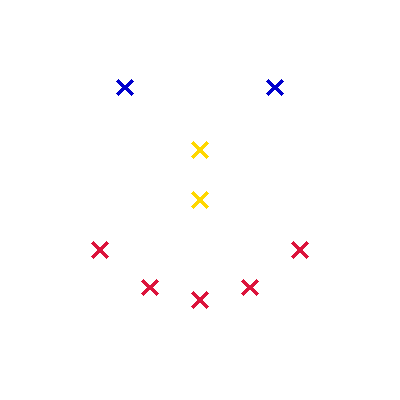

In [4]:
draw_smiley_pointwise(happy, "mediumblue", "gold", "crimson")

The points of the nose and mouth can now be connected to complete the smiley. The eyes, for example, are also displayed as circles to embellish the result. This turns a vector into a smiley. \
The following method $\texttt{draw_smiley}$ draws a finished smiley from an $18$-dimensional vector.

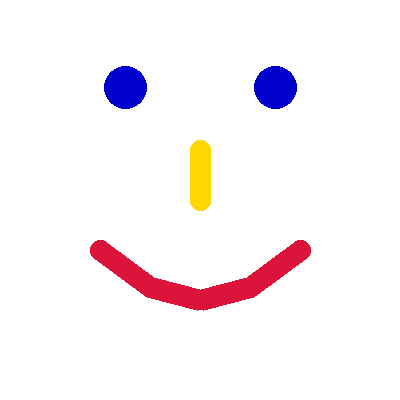

In [5]:
# Render Smiley

def draw_smiley(p: np.array):

    p = copy.copy(p) * 50

    # Draw white background
    draw.rectangle([(0, 0), (400, 400)], "white")

    # Draw eyes
    def draw_ellipse_around_point(draw, center, width=21, fill="black"):
        coords = np.concatenate((center - width, center + width), axis=-1)
        draw.ellipse([(coords[0], coords[1]), (coords[2], coords[3])], fill=fill)

    right_eye_center, left_eye_center = p[0:2], p[2:4]
    draw_ellipse_around_point(draw, left_eye_center, fill="mediumblue")
    draw_ellipse_around_point(draw, right_eye_center, fill="mediumblue")

    # Draw nose
    nose_top, nose_bottom = p[14:16], p[16:18]
    draw.line([tuple(nose_top), tuple(nose_bottom)], fill="gold", width=21)
    draw_ellipse_around_point(draw, nose_top, width=10, fill="gold")
    draw_ellipse_around_point(draw, nose_bottom, width=10, fill="gold")

    # Draw mouth
    mouth = [p[4:6], p[6:8], p[8:10], p[10:12], p[12:14]]
    mouth_tuple = [tuple(x) for x in mouth]
    draw.line(mouth_tuple, fill="crimson", width=21, joint="curve")
    draw_ellipse_around_point(draw, mouth[0], width=10, fill="crimson")
    draw_ellipse_around_point(draw, mouth[4], width=10, fill="crimson")

    display.display(im)


draw_smiley(happy)

A single smiley ($\hat{=}$ $d$-dimensional vector) forms a data point for our database. The database consists of $n$ data points, with $n = 6$ for us. \
Our database therefore consists of six different faces, which (apart from the happy smiley already created above) are defined in the next code section. Each smiley vector is structured in the same order as described above.

In [6]:
# Database

# happy = np.array([5.5, 1.75, 2.5, 1.75, 2, 5, 3, 5.75, 4, 6, 5, 5.75, 6, 5, 4, 3, 4, 4])
sad = np.array([5.5, 2, 2.5, 2, 2, 6, 3, 5.25, 4, 5, 5, 5.25, 6, 6, 4, 2.75, 4, 4])
drunken = np.array([5.75, 2.25, 2.25, 2.25, 2, 6, 3, 5, 4, 5.5, 5, 6, 6, 5, 4, 3, 4, 4.25])
LSD = np.array([6, 2.25, 2, 2.25, 2, 5, 3, 6, 4, 5.5, 5, 5, 6, 6, 4, 3.25, 4, 3.75])
neutral = np.array([5.5, 1.75, 2.5, 1.75, 2, 5, 3, 5.25, 4, 5.5, 5, 5.25, 6, 5, 4, 3, 4, 4])
crazy = np.array([5.5, 3.25, 2.5, 3.25, 2, 5, 3, 6.5, 4, 7, 5, 6.5, 6, 5, 4, 3.5, 4, 4.5])


# will be needed later:
horizontalCoord = (happy[5] + happy[9]) / 2
unenthusiasticIndividual = np.array([5.7, 1.25, 2.3, 1.25, 2, horizontalCoord, 3, horizontalCoord, 4, horizontalCoord, 5, horizontalCoord, 6, horizontalCoord, 4, 2.85, 4, 3.95])
unenthusiasticPoplulation = np.array([5.5, 1.75, 2.5, 1.75, 2, horizontalCoord, 3, horizontalCoord, 4, horizontalCoord, 5, horizontalCoord, 6, horizontalCoord, 4, 3, 4, 4])

smileIndividualVector = happy - unenthusiasticIndividual
smilePopulationVector = happy - unenthusiasticPoplulation

Our database is made up of these six smileys:

In [7]:
#@title Load the database images
# Ignore the code

%%capture --no-display --no-stderr

# Load database images

if(os.path.exists('sample_data/Smiley2D') == False):
  !wget --no-check-certificate https://github.com/annikakrause/PCA_with_smileys/raw/main/sample_data/Smiley2D.zip
  !unzip Smiley2D.zip -d sample_data

dataIm1 = open('sample_data/Smiley2D/out_happy.png','rb').read()
dataIm2 = open('sample_data/Smiley2D/out_sad.png','rb').read()
dataIm3 = open('sample_data/Smiley2D/out_drunken.png','rb').read()
dataIm4 = open('sample_data/Smiley2D/out_LSD.png','rb').read()
dataIm5 = open('sample_data/Smiley2D/out_neutral.png','rb').read()
dataIm6 = open('sample_data/Smiley2D/out_crazy.png','rb').read()
dataIm7 = open('sample_data/Smiley2D/out_unenthusiasticIndividual.png','rb').read()
dataIm8 = open('sample_data/Smiley2D/out_unenthusiasticPopulation.png','rb').read()

picIm1 = open('sample_data/Smiley2D/Matrix blocks 1_v2.png','rb').read()
picIm2 = open('sample_data/Smiley2D/Matrix blocks 2.png','rb').read()
picIm3 = open('sample_data/Smiley2D/Matrix blocks 3.png','rb').read()
picIm4 = open('sample_data/Smiley2D/Matrix blocks 4.png','rb').read()

wiIm1 = widgets.Image(value=dataIm1, format='png', width=110, height=110)
wiIm2 = widgets.Image(value=dataIm2, format='png', width=110, height=110)
wiIm3 = widgets.Image(value=dataIm3, format='png', width=110, height=110)
wiIm4 = widgets.Image(value=dataIm4, format='png', width=110, height=110)
wiIm5 = widgets.Image(value=dataIm5, format='png', width=110, height=110)
wiIm6 = widgets.Image(value=dataIm6, format='png', width=110, height=110)
wiIm7 = widgets.Image(value=dataIm7, format='png', width=110, height=110)
wiIm8 = widgets.Image(value=dataIm8, format='png', width=110, height=110)

wiIm9 = widgets.Image(value=picIm1, format='png', width=800)
wiIm10 = widgets.Image(value=picIm2, format='png', width=950)
wiIm11 = widgets.Image(value=picIm3, format='png', width=750)
wiIm12 = widgets.Image(value=picIm4, format='png', width=550)

database_images = widgets.HBox([wiIm1, wiIm2, wiIm3, wiIm4, wiIm5, wiIm6])
display.display(database_images)

The data matrix $X$ is a $d\times n$ matrix, where the vectors of the $n$ data points form the columns of the data matrix:

$$
X =
\left( \begin{array}{cccccc}
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
v_{1} & v_{2} & v_{3} & v_{4} & v_{5} & v_{6} \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
\end{array}\right)
$$

In [8]:
X_T = np.array([happy, sad, drunken, LSD, neutral, crazy])

The principal component analysis is performed (in contrast to the related singular value decomposition (SVD)$^{[1,2]}$) on mean-subtracted data. \
For this purpose, the arithmetic mean $\mu$ of the data points $v_i$ is calculated as follows:

$$
\mu := \frac{1}{n} \sum_{i=1}^{n}{v_i}
$$
In the programme code, the mean value $\mu$ is denoted by $\texttt{mean}$ or as a line vector by $\texttt{mean_T}$.

In [9]:
mean_T = np.mean(X_T, axis=0)

The mean vector $\mu$ of our smiley database has the following values:

$$
\vec{\mu}= \left(\begin{array}{c} 5.625 \\ 2.20833333 \\ 2.375 \\ 2.20833333 \\ 2 \\ 5.33333333 \\ 3 \\ 5.625 \\ 4 \\ 5.75 \\ 5 \\ 5.625 \\ 6 \\ 5.33333333 \\ 4 \\ 3.08333333 \\ 4 \\ 4.08333333 \end{array}\right)
$$

The average smiley defined by $\mu$ can also be visualised accordingly:

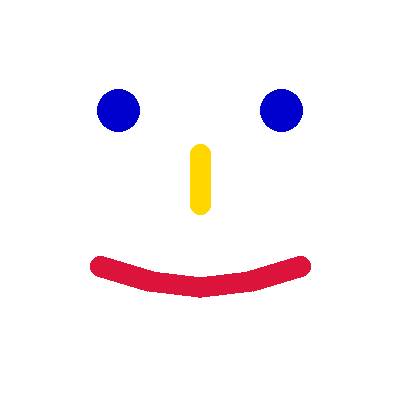

In [10]:
draw_smiley(mean_T)

This mean value then has to be subtracted from all data points $v_i$ in order to obtain normalised copies $v_i' := v_i - \mu$.
These result in the normalised data matrix $\tilde{X} \in \mathbb{R}^{d \times n}$:

$$
\tilde{X} =
\left( \begin{array}{cccccc}
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
v_{1}' & v_{2}' & v_{3}' & v_{4}' & v_{5}' & v_{6}' \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
\end{array}\right)
$$

In [11]:
#@title In pictures
# Ignore the code

display.display(wiIm9)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04A\x00\x00\x015\x08\x06\x00\x00\x00\x08\xea\xfe\xa…

The overall idea of principal component analysis is to project the high-dimensional data points $v_i$, onto a low-dimensional subspace with basis $\lbrace w_j \, | \, j = 1, \ldots, m \rbrace$, where $m < k := min(n, d)$.
This new basis should maximise the variance in order to express as much of the span of the original data points as possible. Since the pointwise scaling of $w_j$ also scales the variance, we impose the additional condition that
$$
\| w_j \|_2 = 1
\hspace{1cm}
$$
for all $j$.

For this purpose, we define the covariance matrix $S \in \mathbb{R}^{d \times d}$:

$$
S := \frac{1}{n} \tilde{X} \tilde{X}^{T}
$$

Subsequently, the eigenvalues $\lambda_i$ of $S$ and their corresponding eigenvectors $w_i$ must be calculated.
Now only the $m$ eigenvectors $w_1, ..., w_m$ of the largest eigenvalues are taken $^{[1]}$. These $m$ so-called principal components form the new basis we are looking for.

$\textit{Note:}$ The number $m$ can be chosen arbitrarily. However, since the principal component analysis provides a maximum of $k-1$ meaningful eigenvectors (i.e. eigenvectors for eigenvalues $\lambda_i \not = 0$), one should choose $m \in \{ 1, ..., k-1\}$ $^{[3]}$. The smaller the choice of $m$, the smaller the target dimension, but the greater the loss of information when converting the data from the original data space to the so-called PCA space. \
The value of an eigenvalue describes the variance that is represented by the associated principal component.

In [12]:
#@title In pictures
# Ignore the code

display.display(wiIm10)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\x1a\x00\x00\x01\x02\x08\x06\x00\x00\x00\x91\xefk…

The principal component analysis is performed in the following programme code, whereby in our example $m = 5$ (in the code $\texttt{M_COMPONENTS}$) is selected. The eigenvectors of the basis found are stored in $\texttt{components}$.

In [13]:
# PCA

M_COMPONENTS = 5

PCA = sklearn.decomposition.PCA(n_components=M_COMPONENTS)
PCA.fit(X_T)
components = PCA.components_

stdDeviations = [np.sqrt(PCA.explained_variance_[0]), np.sqrt(PCA.explained_variance_[1]), np.sqrt(PCA.explained_variance_[2]),
                 np.sqrt(PCA.explained_variance_[3]), np.sqrt(PCA.explained_variance_[4])]


Now we have the required basis, consisting of the $m = 5$ normed basis vectors $w_1, w_2, w_3, w_4$ and $w_5$:

$$
\vec{w_1} = \left(\begin{array}{c} -0.02761514 \\ 0.3934326 \\ 0.02761514 \\ 0.3934326 \\ 0. \\ -0.18074909 \\ 0. \\ 0.36466676 \\ 0. \\ 0.53884804 \\ 0. \\ 0.3728013 \\ 0. \\ 0.18888363 \\ 0. \\ 0.18286673 \\ 0. \\ 0.1574453 \end{array}\right) ,
\hspace{0.4cm}
\vec{w_2} = \left(\begin{array}{c} 0.15837053 \\ 0.05953233 \\ -0.15837053 \\ 0.05953233 \\ 0. \\ -0.42086492 \\ 0. \\ 0.47262055 \\ 0. \\ -0.01420654 \\ 0. \\ -0.4584762 \\ 0. \\ 0.51023183 \\ 0. \\ 0.1353312 \\ 0. \\ -0.23064818 \end{array}\right) ,
\hspace{0.4cm}
\vec{w_3} = \left(\begin{array}{c} -0.11039057 \\ -0.41100849 \\ 0.11039057 \\ -0.41100849 \\ 0. \\ -0.58895954 \\ 0. \\ 0.0654281 \\ 0. \\ 0.24256792 \\ 0. \\ -0.05694117 \\ 0. \\ -0.46659028 \\ 0. \\ 0.01232272 \\ 0. \\ -0.08171833 \end{array}\right) ,
\hspace{0.4cm}
\\
\vec{w_4} = \left(\begin{array}{c} -0.56129356 \\ -0.1103873 \\ 0.56129356 \\ -0.1103873 \\ 0. \\ 0.12942928 \\ 0. \\ 0.29329039 \\ 0. \\ 0.11717182 \\ 0. \\ 0.05174094 \\ 0. \\ 0.37097873 \\ 0. \\ -0.28716583 \\ 0. \\ 0.07912895 \end{array}\right) ,
\hspace{0.4cm}
\vec{w_5} = \left(\begin{array}{c} -0.30818905 \\ 0.33259592 \\ 0.30818905 \\ 0.33259592 \\ 0. \\ -0.30465606 \\ 0. \\ -0.36574707 \\ 0. \\ -0.18851046 \\ 0. \\ -0.49185763 \\ 0. \\ -0.17854551 \\ 0. \\ 0.09917843 \\ 0. \\ 0.20745535 \end{array}\right)
$$

Hence, any smiley can be specified by a $5$-dimensional vector $s$ (as a linear
combination of the new basis vectors) instead of an $18$-dimensional vector.

In order to transform the $5$-dimensional vector $s$ from our so-called PCA space back into an $18$-dimensional vector $s'$ from our so-called data space, which we can visualise as a smiley using the $\texttt{draw_smiley}$ method, a transformation matrix $W$ is required. We obtain this matrix by multiplying each basis vector $w_j$ by its standard deviation, i.e. the square root of its eigenvalue $\sqrt{\lambda_j}$. The resulting vectors $\tilde{w_j}$ are then composed column by column to form the matrix $W$. \
For the conversion from PCA space to data space, the new matrix $W$ is multiplied by the $5$-dimensional smiley vector $s$ and then the vector of the average face $\mu$ is added $^{[4]}$.

$$
s' = W \cdot s + \mu
\hspace{0.5cm}
,
\hspace{3.5cm}
\text{with } \ W =
\left( \begin{array}{cccccc}
\vdots & \vdots & \vdots & \vdots & \vdots \\
\tilde{w_{1}} & \tilde{w_{2}} & \tilde{w_{3}} & \tilde{w_{4}} & \tilde{w_{5}} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
\end{array}\right)
,
\hspace{1.5cm}
\text{where } \ \tilde{w_j} := \sqrt{\lambda_j} \cdot \vec{w_j}
\hspace{1cm}
∀j \in \{1, ..., 5\}
$$


In [14]:
#@title In pictures
# Ignore the code

display.display(wiIm11)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\n\x00\x00\x01\xea\x08\x06\x00\x00\x00\x8d\xd8\xa…

This is implemented by the $\texttt{render_from_params}$ method, which then draws the smiley.

In [15]:
# From 5 to 18 dimensions

W_T = np.array([components[0] * stdDeviations[0], components[1] * stdDeviations[1], components[2] * stdDeviations[2],
                components[3] * stdDeviations[3], components[4] * stdDeviations[4]])

def render_from_params(v_T: np.array, sf1=0.00, sf2=0.00):

    p = copy.copy(mean_T)
    p += np.matmul(v_T, W_T)

    # will be needed later:
    p += sf1 * smileIndividualVector
    p += sf2 * smilePopulationVector

    draw_smiley(p)

The vector
$$
\vec{s}= \left(\begin{array}{c} 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{array}\right)
$$
thus represents the average smiley in our new basis.

The linear combination with arbitrary parameters can also be tested in our interactive tool. The parameters can be changed manually using the $5$ sliders and the resulting smiley is displayed depending on this using the calculation just explained. It is easy to see that the first principal component ($\widehat{=}$ 1st slider) causes the most change to the smiley when it is modified, i.e. it represents the greatest variance, and this decreases from principal component to principal component. \
Using the "Random face" button, a random vector $s$ and thus a random smiley can be generated. The random values for the vector $s$ are normally distributed. By clicking on the "Reset face" button, all vector entries of $s$ are reset to $0$ and thus the average smiley is displayed. \
For example, we start with the smiley for the vector
$$
\vec{s} = \left(\begin{array}{c} 0 \\ 0.5 \\ 1 \\ -0.2 \\ -0.5 \end{array}\right)
$$

In [16]:
#@title Helpers
# Ignore the code

# Important variables and methods

minSliderVal = -2
maxSliderVal = 2

a1 = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
b1 = widgets.FloatSlider(value=0.50, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
c1 = widgets.FloatSlider(value=1.00, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
d1 = widgets.FloatSlider(value=-0.20, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
e1 = widgets.FloatSlider(value=-0.50, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)

baseSliders1 = widgets.VBox([a1, b1, c1, d1, e1])

def getRandomSliderVals():
  return np.random.multivariate_normal(np.zeros(5), np.identity(5))

In [17]:
#@title Tool part 1
# Ignore the code

# Tool part 1

# button definitions:
randomButton1 = widgets.Button(
    description='Random face',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Random face',
)
resetButton1 = widgets.Button(
    description='Reset face',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Reset face',
)

def randomFaceValues1():
  randomVals1 = getRandomSliderVals()
  changeAllBaseSliderValues1(randomVals1[0], randomVals1[1], randomVals1[2], randomVals1[3], randomVals1[4])

def resetFace1():
  changeAllBaseSliderValues1(0.00, 0.00, 0.00, 0.00, 0.00)

def changeAllBaseSliderValues1(v1, v2, v3, v4, v5):
  clear_output(wait=True)
  global a1, b1, c1, d1, e1
  a1 = widgets.FloatSlider(value=v1, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  b1 = widgets.FloatSlider(value=v2, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  c1 = widgets.FloatSlider(value=v3, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  d1 = widgets.FloatSlider(value=v4, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  e1 = widgets.FloatSlider(value=v5, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  out1 = widgets.interactive_output(renderOutput1, {'a1': a1, 'b1': b1, 'c1': c1, 'd1': d1, 'e1': e1})
  baseSliders1 = widgets.VBox([a1, b1, c1, d1, e1])

  mainUi1 = widgets.HBox([out1, baseSliders1])
  ui1 = widgets.VBox([mainUi1, buttons1])
  display.display(ui1)

def renderOutput1(a1, b1, c1, d1, e1):
  v = np.array([a1, b1, c1, d1, e1])
  return render_from_params(v)

out1 = widgets.interactive_output(renderOutput1, {'a1': a1, 'b1': b1, 'c1': c1, 'd1': d1, 'e1': e1})

resetButton1.on_click(lambda _:resetFace1())
randomButton1.on_click(lambda _:randomFaceValues1())
buttons1 = widgets.HBox([randomButton1, resetButton1])
mainUi1 = widgets.HBox([out1, baseSliders1])
ui1 = widgets.VBox([mainUi1, buttons1])

display.display(ui1)


Conversely, the transformation from data space to PCA space, i.e. from the representation in $18$ to that in $5$ dimensions, is also possible. If we have a given smiley ($\hat{=}$ $18$-dimensional vector $s'$) and want to obtain the linear combination of our new basis vectors that corresponds to the given smiley, the system of linear equations
$$
W \cdot s = (s' - \mu)
$$
needs to be solved.

This is achieved by the matrix multiplication
$$
\tilde{s} = W^{-1} \cdot (s' - \mu)
$$

$\tilde{s}$ denotes the resulting $5$-dimensional vector in PCA space.

$\textit{Note: }$ Since $W$ is not a square matrix, $W^{-1}$ designates the pseudo inverse of $W$.

In [18]:
#@title In pictures
# Ignore the code

display.display(wiIm12)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xff\x00\x00\x00\xd3\x08\x06\x00\x00\x00\x16\n|F\…

The $\texttt{getLinComb}$ method is responsible for this calculation:

In [19]:
# From 18 to 5 dimensions

def getLinComb(face: np.array):
  res_T = face - mean_T
  return np.matmul(res_T, np.linalg.pinv(W_T))

We can therefore describe already known smileys from the data space ($\hat{=} 18$-dimensional vectors) in our new basis. For example, we already know the smileys in the database. Clicking on the button under the respective image of one of these smileys performs the calculation just explained. In addition to displaying the correct smiley, the parameters of the $5$ base vectors are automatically adjusted to the corresponding values via the sliders (deactivated here). \
This function can be tried out directly here:

In [20]:
#@title Helpers
# Ignore the code

# Important variables

a2 = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
b2 = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
c2 = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
d2 = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
e2 = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)

baseSliders2 = widgets.VBox([a2, b2, c2, d2, e2])

In [21]:
#@title Tool part 2
# Ignore the code

# Tool part 2

# database images button definitions:
face1Button2 = widgets.Button(
    description='Face 1',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 1',
    layout=Layout(width='70%'),
)
face2Button2 = widgets.Button(
    description='Face 2',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 2',
    layout=Layout(width='70%'),
)
face3Button2 = widgets.Button(
    description='Face 3',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 3',
    layout=Layout(width='70%'),
)
face4Button2 = widgets.Button(
    description='Face 4',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 4',
    layout=Layout(width='70%'),
)
face5Button2 = widgets.Button(
    description='Face 5',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 5',
    layout=Layout(width='70%'),
)
face6Button2 = widgets.Button(
    description='Face 6',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 6',
    layout=Layout(width='70%'),
)


def changeAllBaseSliderValues2(v1, v2, v3, v4, v5):
  clear_output(wait=True)
  global a2, b2, c2, d2, e2
  a2 = widgets.FloatSlider(value=v1, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
  b2 = widgets.FloatSlider(value=v2, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
  c2 = widgets.FloatSlider(value=v3, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
  d2 = widgets.FloatSlider(value=v4, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
  e2 = widgets.FloatSlider(value=v5, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
  out2 = widgets.interactive_output(renderOutput2, {'a2': a2, 'b2': b2, 'c2': c2, 'd2': d2, 'e2': e2})
  baseSliders2 = widgets.VBox([a2, b2, c2, d2, e2])

  slidersAndStuff2 = widgets.VBox([baseSliders2, faces2])
  mainUi2 = widgets.HBox([out2, slidersAndStuff2])
  display.display(mainUi2)


def renderOutput2(a2, b2, c2, d2, e2):
  v = np.array([a2, b2, c2, d2, e2])
  return render_from_params(v)


out2 = widgets.interactive_output(renderOutput2, {'a2': a2, 'b2': b2, 'c2': c2, 'd2': d2, 'e2': e2})

def handle_ev1_2():
  linComb = getLinComb(happy)
  changeAllBaseSliderValues2(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4])

def handle_ev2_2():
  linComb = getLinComb(sad)
  changeAllBaseSliderValues2(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4])

def handle_ev3_2():
  linComb = getLinComb(drunken)
  changeAllBaseSliderValues2(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4])

def handle_ev4_2():
  linComb = getLinComb(LSD)
  changeAllBaseSliderValues2(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4])

def handle_ev5_2():
  linComb = getLinComb(neutral)
  changeAllBaseSliderValues2(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4])

def handle_ev6_2():
  linComb = getLinComb(crazy)
  changeAllBaseSliderValues2(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4])


face1_2 = widgets.VBox([wiIm1, face1Button2])
face2_2 = widgets.VBox([wiIm2, face2Button2])
face3_2 = widgets.VBox([wiIm3, face3Button2])
face4_2 = widgets.VBox([wiIm4, face4Button2])
face5_2 = widgets.VBox([wiIm5, face5Button2])
face6_2 = widgets.VBox([wiIm6, face6Button2])

face1_2.layout.align_items = 'center'
face2_2.layout.align_items = 'center'
face3_2.layout.align_items = 'center'
face4_2.layout.align_items = 'center'
face5_2.layout.align_items = 'center'
face6_2.layout.align_items = 'center'

faces2 = widgets.HBox([face1_2, face2_2, face3_2, face4_2, face5_2, face6_2])

face1Button2.on_click(lambda _:handle_ev1_2())
face2Button2.on_click(lambda _:handle_ev2_2())
face3Button2.on_click(lambda _:handle_ev3_2())
face4Button2.on_click(lambda _:handle_ev4_2())
face5Button2.on_click(lambda _:handle_ev5_2())
face6Button2.on_click(lambda _:handle_ev6_2())

slidersAndStuff2 = widgets.VBox([baseSliders2, faces2])
mainUi2 = widgets.HBox([out2, slidersAndStuff2])
display.display(mainUi2)


We can not only create faces, but also manipulate existing faces. A smile from our smiley is a good choice for this. \
To do so, we first need to calculate a smile vector $l_1$ from a smiling and a non-smiling smiley by taking the difference between the two. \
In our example, we take the difference between the following two smileys (already calculated above in the database as $\texttt{smileIndividualVector}$):

In [22]:
# smileIndividualVector = happy - unenthusiasticIndividual

smileIndividualVector_images = widgets.HBox([wiIm1, wiIm7])
display.display(smileIndividualVector_images)

As you can conclude, $l_1$ changes the position of the eyes as well as the position and length of the nose in addition to the mouth. This is due to the fact that when calculating the smile vector $l_1$, we compare any two smileys, one of which is smiling and one of which is not. However, this does not correspond to the difference between the smile and non-smile of the "same" smiley. \
If we consider the smileys as "real" (stylised) faces, we would not expect a change in the position of the eyes and nose when "the same" smiley smiles, but only a modification of the mouth. This result can also be obtained using the difference of smileys method if all smiling and non-smiling smileys in a representative data set are subtracted from each other and the average is calculated from the results. \
Such an "individuality-adjusted" smile vector $l_2$ is represented in the interactive tool by the "Smile $l_2$" slider, which only modifies the mouth. To achieve this, we simply took the difference between the two following smileys (calculated as $\texttt{smilePopulationVector}$ after the database above), which only differ in terms of the mouth.

In [23]:
# smilePopulationVector = happy - unenthusiasticPoplulation

smilePopulationVector_images = widgets.HBox([wiIm1, wiIm8])
display.display(smilePopulationVector_images)

This face modification can also be tested here by changing the corresponding "Smile"-sliders:

In [24]:
#@title Tool part 3
# Ignore the code

# Tool part 3

smileIndividual3 = widgets.FloatSlider(value=0.00, min=-2.00, max=2.00, step=0.05, description='Smile l₁', orientation='vertical', continuous_update=False)
smilePopulation3 = widgets.FloatSlider(value=0.00, min=-2.00, max=2.00, step=0.05, description='Smile l₂', orientation='vertical', continuous_update=False)

def renderOutput3(sf1, sf2):
  v = np.zeros(5)
  return render_from_params(v, sf1, sf2)

out3 = widgets.interactive_output(renderOutput3, {'sf1': smileIndividual3, 'sf2': smilePopulation3})
slidersAligned3 = widgets.HBox([smileIndividual3, smilePopulation3])
mainUi3 = widgets.HBox([out3, slidersAligned3])

display.display(mainUi3)


Finally, we come to the interactive tool where you can see the results of the principal component analysis and our calculations using the smiley. \
By default, the image shows the average smiley, but the sliders and buttons can be used to modify the smiley as required. All the functions presented so far are combined and can be tested here. Have fun with it!

The following programme code is only responsible for the display and is conceptually irrelevant.

In [25]:
#@title Helpers
# Ignore the code

# Important variables and methods

a = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
b = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
c = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
d = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
e = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
smileIndividual = widgets.FloatSlider(value=0.00, min=-2.00, max=2.00, step=0.05, description='Smile l₁', orientation='vertical', continuous_update=False)
smilePopulation = widgets.FloatSlider(value=0.00, min=-2.00, max=2.00, step=0.05, description='Smile l₂', orientation='vertical', continuous_update=False)

baseSliders = widgets.VBox([a, b, c, d, e])

In [26]:
#@title Main tool
# Ignore the code


randomButton = widgets.Button(
    description='Random face',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Random face',
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)

resetButton = widgets.Button(
    description='Reset face',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Reset face',
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)

# database images button definitions:
face1Button = widgets.Button(
    description='Face 1',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 1',
    layout=Layout(width='70%'),
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)
face2Button = widgets.Button(
    description='Face 2',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 2',
    layout=Layout(width='70%'),
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)
face3Button = widgets.Button(
    description='Face 3',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 3',
    layout=Layout(width='70%'),
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)
face4Button = widgets.Button(
    description='Face 4',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 4',
    layout=Layout(width='70%'),
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)
face5Button = widgets.Button(
    description='Face 5',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 5',
    layout=Layout(width='70%'),
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)
face6Button = widgets.Button(
    description='Face 6',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 6',
    layout=Layout(width='70%'),
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)


def randomFaceValues():
  randomVals = getRandomSliderVals()
  changeAllSliderValues(randomVals[0], randomVals[1], randomVals[2], randomVals[3], randomVals[4])

def resetFace():
  changeAllSliderValues(0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00)


def changeAllSliderValues(v1, v2, v3, v4, v5, sf1=5.00, sf2=5.00): # smileIndividual is set to sf1, if sf1!=5.00; smilePopulation is set to sf2, if sf2!=5.00
  clear_output(wait=True)
  global a, b, c, d, e, smileIndividual, smilePopulation
  a = widgets.FloatSlider(value=v1, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  b = widgets.FloatSlider(value=v2, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  c = widgets.FloatSlider(value=v3, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  d = widgets.FloatSlider(value=v4, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  e = widgets.FloatSlider(value=v5, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  if(sf1 != 5.00):
    smileIndividual = widgets.FloatSlider(value=sf1, min=-2.00, max=2.00, step=0.05, description='Smile l₁', orientation='vertical', continuous_update=False)
  if(sf2 != 5.00):
    smilePopulation = widgets.FloatSlider(value=sf2, min=-2.00, max=2.00, step=0.05, description='Smile l₂', orientation='vertical', continuous_update=False)
  out = widgets.interactive_output(renderOutput, {'a': a, 'b': b, 'c': c, 'd': d, 'e': e, 'sf1': smileIndividual, 'sf2': smilePopulation})
  baseSliders = widgets.VBox([a, b, c, d, e])

  slidersAligned = widgets.HBox([baseSliders, smileIndividual, smilePopulation])
  slidersAndStuff = widgets.VBox([slidersAligned, faces])
  mainUi = widgets.HBox([out, slidersAndStuff])
  ui = widgets.VBox([mainUi, buttons])
  display.display(ui)


def renderOutput(a, b, c, d, e, sf1, sf2):
  v = np.array([a, b, c, d, e])
  return render_from_params(v, sf1, sf2)

out = widgets.interactive_output(renderOutput, {'a': a, 'b': b, 'c': c, 'd': d, 'e': e, 'sf1': smileIndividual, 'sf2': smilePopulation})


def handle_ev1():
  linComb = getLinComb(happy)
  changeAllSliderValues(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4], 0.00, 0.00)

def handle_ev2():
  linComb = getLinComb(sad)
  changeAllSliderValues(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4], 0.00, 0.00)

def handle_ev3():
  linComb = getLinComb(drunken)
  changeAllSliderValues(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4], 0.00, 0.00)

def handle_ev4():
  linComb = getLinComb(LSD)
  changeAllSliderValues(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4], 0.00, 0.00)

def handle_ev5():
  linComb = getLinComb(neutral)
  changeAllSliderValues(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4], 0.00, 0.00)

def handle_ev6():
  linComb = getLinComb(crazy)
  changeAllSliderValues(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4], 0.00, 0.00)


face1 = widgets.VBox([wiIm1, face1Button])
face2 = widgets.VBox([wiIm2, face2Button])
face3 = widgets.VBox([wiIm3, face3Button])
face4 = widgets.VBox([wiIm4, face4Button])
face5 = widgets.VBox([wiIm5, face5Button])
face6 = widgets.VBox([wiIm6, face6Button])

face1.layout.align_items = 'center'
face2.layout.align_items = 'center'
face3.layout.align_items = 'center'
face4.layout.align_items = 'center'
face5.layout.align_items = 'center'
face6.layout.align_items = 'center'

faces = widgets.HBox([face1, face2, face3, face4, face5, face6])

resetButton.on_click(lambda _:resetFace())
randomButton.on_click(lambda _:randomFaceValues())
face1Button.on_click(lambda _:handle_ev1())
face2Button.on_click(lambda _:handle_ev2())
face3Button.on_click(lambda _:handle_ev3())
face4Button.on_click(lambda _:handle_ev4())
face5Button.on_click(lambda _:handle_ev5())
face6Button.on_click(lambda _:handle_ev6())

buttons = widgets.HBox([randomButton, resetButton])

slidersAligned = widgets.HBox([baseSliders, smileIndividual, smilePopulation])
slidersAndStuff = widgets.VBox([slidersAligned, faces])
mainUi = widgets.HBox([out, slidersAndStuff])
ui = widgets.VBox([mainUi, buttons])

display.display(ui)


How such an example for principal component analysis can be transferred to more dimensions and more complex applications is explained in the following notebook on PCA on faces in 3D:
https://colab.research.google.com/drive/16oMHRt5kj-X-2sBOE5ziw43CgdvJ6mm6?usp=sharing

### Sources:

$[1]$ Takio Kurita. “Principal Component Analysis (PCA)”. In: Computer Vision. Springer eBook Collection. Cham: Springer International Publishing and Springer, 2019, pp. 1–4. ISBN: 978-3-030-03243-2. DOI: 10.1007/978-3-030-03243-2_649-1. \
$[2]$ Kaare Brandt Petersen and Michael Syskind Pedersen. “The Matrix Cookbook”. In: Technical University of Denmark 7.15 (2012). URL: https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf. \
$[3]$ M. Turk and A. Pentland. “Eigenfaces for recognition”. In: Journal of cognitive neuroscience 3.1 (1991), pp. 71–86. ISSN: 0898-929X. DOI: 10.1162/jocn.1991.3.1.71. \
$[4]$ Thomas Albrecht et al. “Posterior shape models”. In: Medical Image Analysis 17.8 (2013), pp. 959–973. ISSN: 1361-8415. DOI: 10.1016/j.media.2013.05.010. URL: https://www.sciencedirect.com/science/article/pii/S1361841513000844.

